#### 目标检测不但要对物体进行分类，还要框出物体的位置

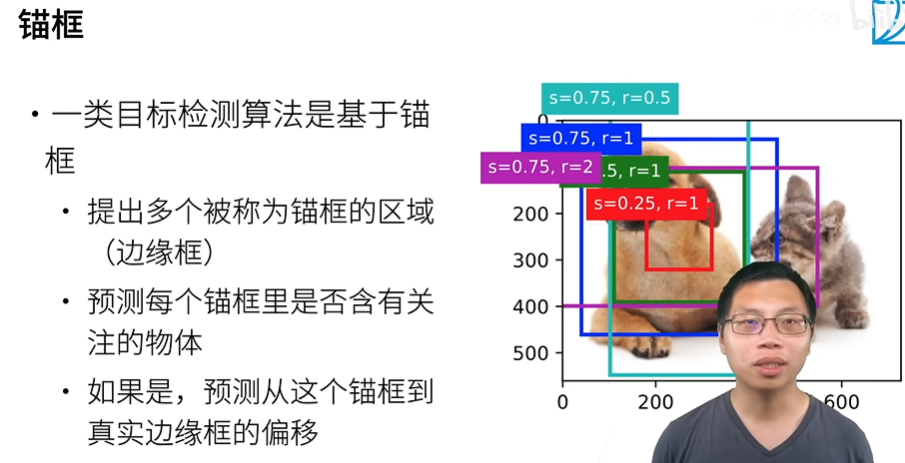

#### IoU-交并比：评估锚框和物体真实边缘框相似度

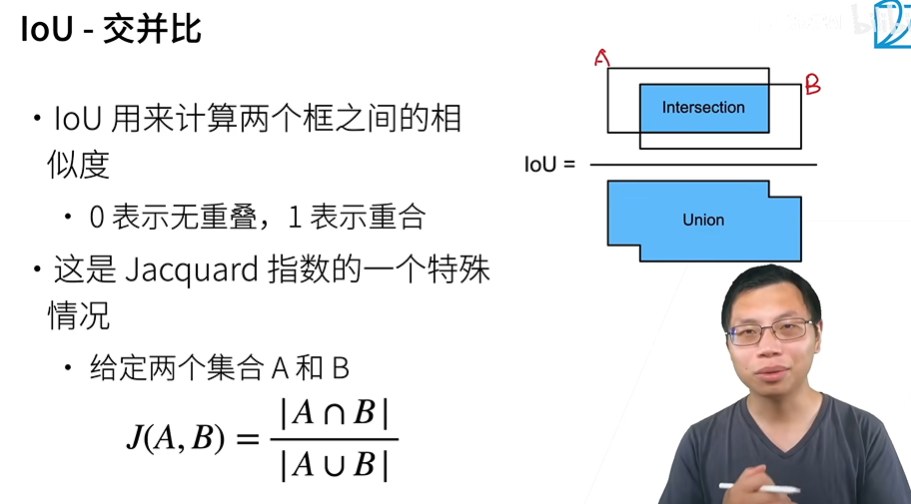

#### 每张图片读进来都需要对锚框进行标号
目标检测可能是一张一张图片读的，因为内存原因

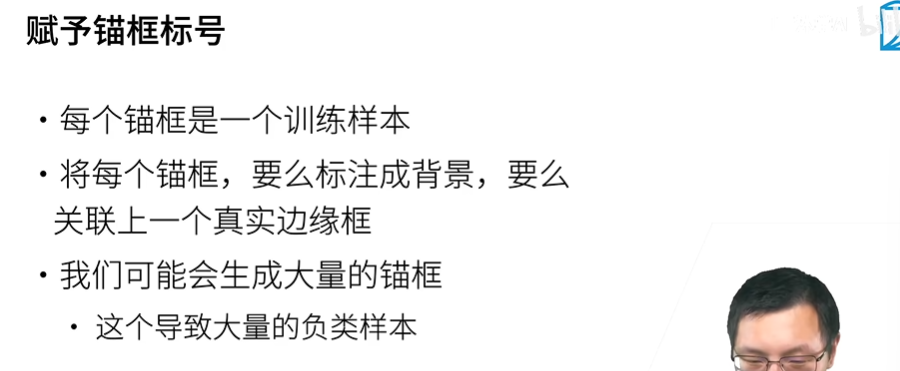

每个锚框与每个真实边缘框算交并比，结果保存在矩阵中，挑选其中最大值，将该边缘框与该锚框关联起来。删除该行和列，继续找最大值，将边缘框分配给某个锚框,直到边缘框都被分配完。

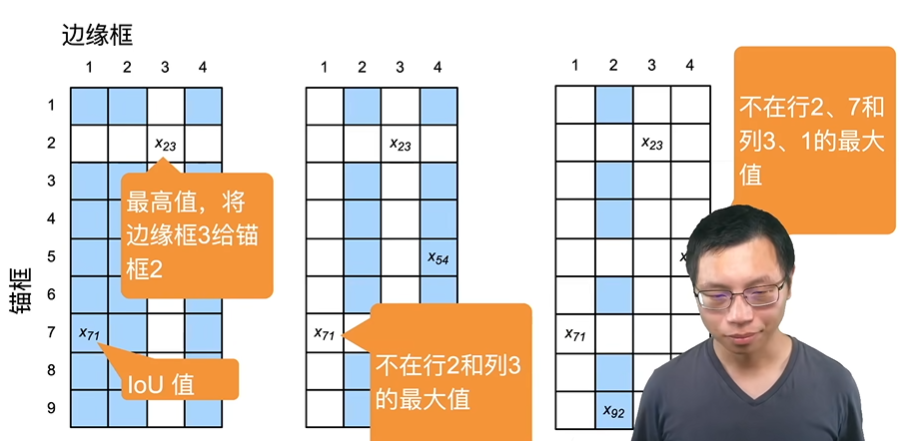

## 使用非极大值抑制（NMS）输出
NMS能够合并相似预测。举例：蓝色框预测dog=0.9，绿色框与红色框分别与这个蓝色框做交并比，若theta=0.5，显然看起来这两组结果大于0.5则删除这两个锚框，紫色框与蓝色框交并比显然不足0.5因此保留

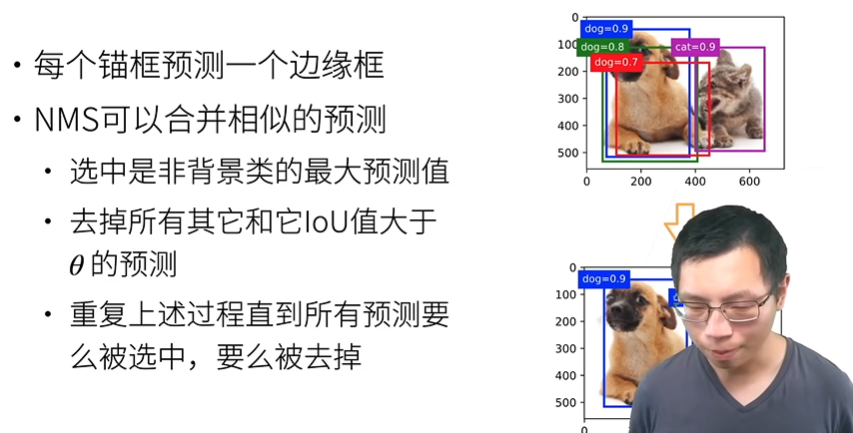

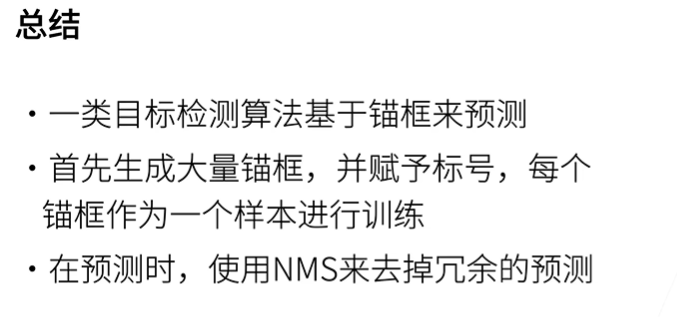

In [1]:
%matplotlib inline
import torch
from d2l import torch as d2l

torch.set_printoptions(2)  # 精简输出精度

## SSD生成锚框的算法实现
此算法原理：以每个像素为中心生成 n + m - 1 个锚框

下图s与r的解释如下：s^2 是锚框与图像的面积比（s是w与W之比，也是h与H之比），r是锚框的宽高比w/h

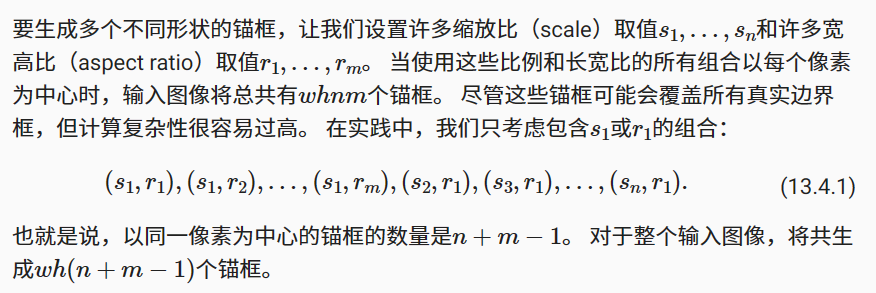
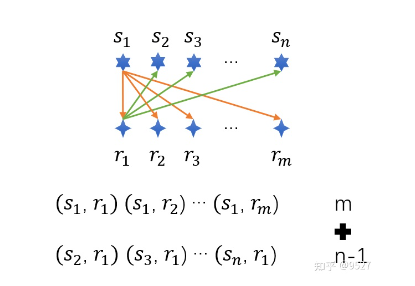

In [35]:
# ratio为锚框的宽高比
# data.shape: (batch_size, num_channels, height, width)
def multibox_prior(data, sizes, ratios): 
    """
    desc: 对特征图每个像素中心分别生成 len(sizes) + len(ratios) - 1 个锚框
    return: 所有锚框的相对坐标，(batch_size, 锚框总数，4)，乘以原图尺寸便可得到绝对坐标
    """
    in_height, in_width = data.shape[-2:] # 获取特征图的高宽
    device, num_sizes, num_ratios = data.device, len(sizes), len(ratios)
    boxes_per_pixel = (num_sizes + num_ratios - 1) # 一个像素点产生的锚框数
    size_tensor = torch.tensor(sizes, device=device)
    ratio_tensor = torch.tensor(ratios, device=device)
    
    # 为了将锚点移动到像素的中心，需要设置偏移量。
    # 因为一个像素的高为1且宽为1，我们选择偏移我们的中心0.5
    offset_h, offset_w = 0.5, 0.5
    step_h = 1.0 / in_height
    step_w = 1.0 / in_width
    
    # 根据图片的尺寸生成每个像素所有的相对中心点 
    # 这些相对中心坐标 * 原始图片大小 = 绝对中心坐标
    center_h = (torch.arange(in_height, device=device) + offset_h) * step_h
    center_w = (torch.arange(in_width, device=device) + offset_w) * step_w
    shift_y, shift_x = torch.meshgrid(center_h, center_w)
    shift_y, shift_x = shift_y.reshape(-1), shift_x.reshape(-1)
    
    # 生成boxes_per_pixel对锚框的高宽，zip(w,h)可以分别取出一组高宽
    w = torch.cat((size_tensor * torch.sqrt(ratio_tensor[0]),
                   sizes[0] * torch.sqrt(ratio_tensor[1:])))\
                   * in_height / in_width # 正方形时候 in_height / in_width=1 等于没有这两项
    h = torch.cat((size_tensor / torch.sqrt(ratio_tensor[0]),
                   sizes[0] / torch.sqrt(ratio_tensor[1:])))
    
    # 除以2来获得半高和半宽，每一行对应一个锚框的左上坐标偏差和右下坐标偏差（从中心点分别加上偏差即可得到锚框的相对坐标）
    anchor_manipulations = torch.stack((-w, -h, w, h)).T.repeat(in_height * in_width, 1) / 2
    
    # 每个中心点都将生成 boxes_per_pixel 个锚框，因此一组中心坐标重复boxes_per_pixel次
    # out_grid的形状是(生成的锚框总数，4)
    out_grid = torch.stack([shift_x, shift_y, shift_x, shift_y], dim=1).repeat_interleave(boxes_per_pixel, dim=0)
    
    # 两者相加，得到的就是根据这个特征图生成的所有锚框。 结果是左上右下表示法（左上相对坐标，右下相对坐标）
    # 相当于从某一像素的中心点，往左走半个宽，往上走半个高，得到左上坐标，中心点往右走半个宽，往下走半个高，得到右下坐标
    output = out_grid + anchor_manipulations
    
    # 增加批量维作为第一个维度
    return output.unsqueeze(0)

torch.repeat()与torch.repeat_interleave()的区别在于：后者是对每个元素先重复，而前者是整组重复

In [36]:
img = d2l.plt.imread('../img/catdog.jpg')
h, w = img.shape[:2]
print(h, w)
X = torch.rand(size=(1, 3, h, w))

# 对特征图X的每个像素生成锚框
Y = multibox_prior(X, sizes=[0.75, 0.5, 0.25], ratios=[1, 2, 0.5])
Y, Y.shape # 返回的锚框变量Y的形状是（批量大小，锚框的数量，4）

316 410


(tensor([[[-0.29, -0.37,  0.29,  0.38],
          [-0.19, -0.25,  0.19,  0.25],
          [-0.10, -0.12,  0.10,  0.13],
          ...,
          [ 0.90,  0.87,  1.10,  1.12],
          [ 0.59,  0.73,  1.41,  1.26],
          [ 0.79,  0.47,  1.20,  1.53]]]),
 torch.Size([1, 647800, 4]))

将锚框变量Y的形状更改为(图像高度,图像宽度,以同一像素为中心的锚框的数量,4)后，我们可以获得指定像素为中心的所有锚框。 （锚框总数 = 图像高 * 图像宽 * 以同一像素为中心的锚框的数量，因此可以这样reshape）

In [37]:
boxes = Y.reshape(h, w, 5, 4)
boxes[150, 120, 0, :] # 访问（150，120）位置生成的第一个锚框

tensor([0.00, 0.10, 0.58, 0.85])

定义函数在图像中以某个像素为中心的所有锚框

In [38]:
# bboxes.shape : (锚框数量，4)
def show_bboxes(axes, bboxes, labels=None, colors=None):
    """显示图像某像素位置的所有边界框"""
    def _make_list(obj, default_values=None):
        if obj is None:
            obj = default_values
        elif not isinstance(obj, (list, tuple)):
            obj = [obj]
        return obj

    labels = _make_list(labels)
    colors = _make_list(colors, ['b', 'g', 'r', 'm', 'c'])
    for i, bbox in enumerate(bboxes):
        color = colors[i % len(colors)]
        rect = d2l.bbox_to_rect(bbox.detach().numpy(), color)
        axes.add_patch(rect)
        if labels and len(labels) > i:
            text_color = 'k' if color == 'w' else 'w'
            axes.text(rect.xy[0], rect.xy[1], labels[i],
                      va='center', ha='center', fontsize=9, color=text_color,
                      bbox=dict(facecolor=color, lw=0))

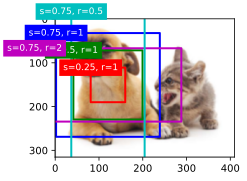

In [39]:
d2l.set_figsize()
bbox_scale = torch.tensor((w, h, w, h))
fig = d2l.plt.imshow(img)
show_bboxes(fig.axes, boxes[150, 120, :, :] * bbox_scale, # 相对坐标 * 图片尺寸 = 绝对坐标
            ['s=0.75, r=1', # 五个标签
             's=0.5, r=1', 
             's=0.25, r=1', 
             's=0.75, r=2',
             's=0.75, r=0.5'])

## 交并比IoU的实现
使用交并比来衡量锚框和真实边界框之间、以及不同锚框之间的相似度。

In [40]:
def box_iou(boxes1, boxes2):
    """计算两个锚框或边界框列表中成对的交并比"""
    # 面积(=含多少像素)
    box_area = lambda boxes: ((boxes[:, 2] - boxes[:, 0]) * 
                              (boxes[:, 3] - boxes[:, 1]))
    # boxes1,boxes2,areas1,areas2的形状:
    # boxes1：(boxes1的数量,4)
    # boxes2：(boxes2的数量,4)
    # areas1：(boxes1的数量,)
    # areas2：(boxes2的数量,)
    areas1 = box_area(boxes1)
    areas2 = box_area(boxes2)
    
    # 得到相交区域的左上右下坐标，保证坐标均大于0
    # inter_upperlefts,inter_lowerrights,inters的形状:(boxes1的数量,boxes2的数量,2)
    inter_upperlefts = torch.max(boxes1[:, None, :2], boxes2[:, :2])
    inter_lowerrights = torch.min(boxes1[:, None, 2:], boxes2[:, 2:])
    inters = (inter_lowerrights - inter_upperlefts).clamp(min=0)
    
    # 交
    # inter_areas and union_areas的形状:(boxes1的数量,boxes2的数量)
    inter_areas = inters[:, :, 0] * inters[:, :, 1]
    # 并
    union_areas = areas1[:, None] + areas2 - inter_areas
    return inter_areas / union_areas

## 将真实边界框分配给锚框的实现
初次分配：假设锚框有na个，真实边界框有nb个，构造矩阵 na x nb 存储交并比。依次取出矩阵最大值，将列所代表的真实边界框分配给这行代表的锚框，直到所有真实边界框被分配完。

再分配：随后，只遍历剩余的锚框（未分配到真实边界框），扫描该行，找到与其交并比最大的真实边界框，只有当此交并比大于预定义的阈值，才将这个真实边界框分配给它

In [41]:
def assign_anchor_to_bbox(ground_truth, anchors, device, iou_threshold=0.5):
    """
    为锚框分配真实边界框，可能存在多个锚框分配到同一个真实边界框
    return: 锚框与真实边界框的映射，形状：(num_anchors,) ，存放的真实边界框的索引
    """
    num_anchors, num_gt_boxes = anchors.shape[0], ground_truth.shape[0]
    # 位于第i行和第j列的元素x_ij是锚框i和真实边界框j的IoU
    jaccard = box_iou(anchors, ground_truth)
    # 对于每个锚框，分配的真实边界框, -1代表未分配真实边界框
    anchors_bbox_map = torch.full((num_anchors,), -1, dtype=torch.long,
                                  device=device)
    # 根据阈值，决定是否分配真实边界框
    # max_ious和indices的形状（num_anchors,）
    max_ious, indices = torch.max(jaccard, dim=1)
    # 满足分配真实边界框条件的锚框的索引
    anc_i = torch.nonzero(max_ious >= iou_threshold).reshape(-1)
    # 找到分配给它的真实边缘框的索引
    box_j = indices[max_ious >= iou_threshold]
    # 正式分配真实边界框
    anchors_bbox_map[anc_i] = box_j
    
    col_discard = torch.full((num_anchors,), -1)
    row_discard = torch.full((num_gt_boxes,), -1)
    for _ in range(num_gt_boxes):
        max_idx = torch.argmax(jaccard)
        # 获取最大值所在的行和列（这种方式有点牛逼）
        box_idx = (max_idx % num_gt_boxes).long()
        anc_idx = (max_idx / num_gt_boxes).long()
        # 分配
        anchors_bbox_map[anc_idx] = box_idx
        # 将该行和列丢弃
        jaccard[:, box_idx] = col_discard
        jaccard[anc_idx, :] = row_discard
    return anchors_bbox_map    

## 标记类别和偏移量
为分配到真实边界框B的锚框A标记类别和偏移量，类别标记为与B相同。锚框A的偏移量将根据B和A中心坐标的相对位置以及这两个框的相对大小进行标记。

鉴于数据集内不同的框的位置和大小不同，我们可以对那些相对位置和大小应用变换，使其获得分布更均匀且易于拟合的偏移量。 下面给出一种常见的变换,给定框A和B，中心坐标分别为(xa,ya),(xb,yb),宽度分别是wa和wb，高度分别是ha和hb。可以将A的偏移量标记为：
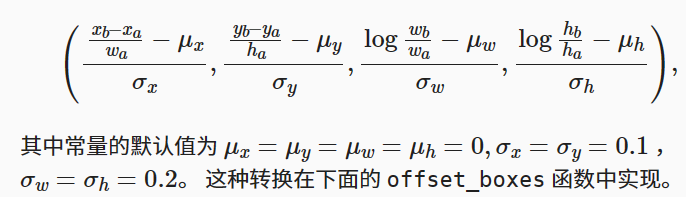

In [42]:
def offset_boxes(anchors, assigned_bb, eps=1e-6):
    """计算锚框与真实边界框的偏移量"""
    # 转换成中心宽高表示法
    c_anc = d2l.box_corner_to_center(anchors) 
    c_assigned_bb = d2l.box_corner_to_center(assigned_bb)
    # 复现上述公式
    offset_xy = 10 * (c_assigned_bb[:, :2] - c_anc[:, :2]) / c_anc[:, 2:]
    offset_wh = 5 * torch.log(eps + c_assigned_bb[:, 2:] / c_anc[:, 2:])
    offset = torch.cat([offset_xy, offset_wh], axis = 1)
    return offset

如果一个锚框没有被分配真实边界框，我们只需将锚框的类别标记为背景类。 背景类别的锚框通常被称为负类锚框，其余的被称为正类锚框。

我们使用真实边界框（labels参数）实现以下multibox_target函数，来标记锚框的类别和偏移量（anchors参数）。此函数将背景类别的索引设置为零，然后将新类别的整数索引递增一。

In [43]:
def multibox_target(anchors, labels):
    """
    把锚框映射到真实边界框
    使用真实边界框的类别和坐标来标记锚框的类别，以及计算两者的偏移量
    return：锚框到真实边界框的偏移，锚框的类别，mask变量
    labels的形状（batch_size, 真实边界框数量, 5）
    """
    batch_size, anchors = labels.shape[0], anchors.squeeze(0)
    batch_offset, batch_mask, batch_class_labels = [], [], []
    device, num_anchors = anchors.device, anchors.shape[0]
    for i in range(batch_size):
        # 拿出第i个批量的所有真实边界框(label形状：（真实边界框数，5）)
        label = labels[i, :, :]
        # 为锚框分配真实边界框
        anchors_bbox_map = assign_anchor_to_bbox(label[:, 1:], anchors, device)
        # 未分配到边界框的锚框 bbox_mask = [0] * 4 ，bbox_mask形状：（锚框数，4）
        bbox_mask = ((anchors_bbox_map >= 0).float().unsqueeze(-1)).repeat(1, 4)
        # 将锚框的类别标签和分配的边界框坐标初始化为零（类别标签为0代表是背景类）
        class_labels = torch.zeros(num_anchors, dtype=torch.long,
                                   device=device)
        assigned_bb = torch.zeros((num_anchors, 4), dtype=torch.float32,
                                  device=device)
       
        # 使用真实边界框来标记锚框的类别（锚框的类别与分配到的真实边界框的类别相同）。
        # 如果一个锚框没有被分配，标记其为背景（值为零，初始化已经默认全设置为0类了）
        indices_true = torch.nonzero(anchors_bbox_map >= 0) # 分配到真实边界框的锚框索引
        bb_idx = anchors_bbox_map[indices_true]  # 上述锚框对应的真实边界框索引
        # 将真实边界框的类别 + 1 作为该锚框属于的类别
        # 因为0类已经被视为背景类了，然而数据集中的类别是从0开始开始标的
        class_labels[indices_true] = label[bb_idx, 0].long() + 1
        assigned_bb[indices_true] = label[bb_idx, 1:]
        
        # 计算锚框与其分配到的真实边界框之间的偏移量（背景框偏移量为0）
        # 偏移量列的格式：（中心点的偏移，宽高的偏移）
        offset = offset_boxes(anchors, assigned_bb) * bbox_mask
        batch_offset.append(offset.reshape(-1)) # 将一个批量的锚框偏移量拉平放入b_o中
        batch_mask.append(bbox_mask.reshape(-1))
        batch_class_labels.append(class_labels)
    
    # bbox_offset，bbox_mask，class_labels形状（batch_size, 锚框数 * 4）
    bbox_offset = torch.stack(batch_offset)
    bbox_mask = torch.stack(batch_mask)
    class_labels = torch.stack(batch_class_labels)
    return (bbox_offset, bbox_mask, class_labels)

## 一个例子
我们已经为加载图像中的狗和猫定义了真实边界框,ground_truth第一个元素是类别 （0代表够，1代表猫），其余四个元素是边界框的左上右下坐标。

我们还构建了五个锚框，用左上右下坐标表示。随后在图像中绘制出真实边界框以及锚框。

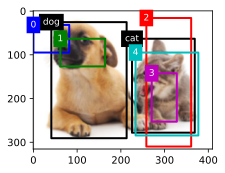

In [44]:
ground_truth = torch.tensor([[0, 0.1, 0.08, 0.52, 0.92],
                             [1, 0.55, 0.2, 0.9, 0.88]])
anchors = torch.tensor([[0, 0.1, 0.2, 0.3], 
                        [0.15, 0.2, 0.4, 0.4],
                        [0.63, 0.05, 0.88, 0.98], 
                        [0.66, 0.45, 0.8, 0.8],
                        [0.57, 0.3, 0.92, 0.9]])

fig = d2l.plt.imshow(img)
# 绘制真实边界框
show_bboxes(fig.axes, ground_truth[:, 1:] * bbox_scale, ['dog', 'cat'], 'k')
# 绘制5个锚框
show_bboxes(fig.axes, anchors * bbox_scale, ['0', '1', '2', '3', '4']);

使用上面定义的multibox_target函数，我们可以根据狗和猫的真实边界框，标注这些锚框的分类和偏移量。

In [51]:
labels = multibox_target(anchors.unsqueeze(dim=0),
                         ground_truth.unsqueeze(dim=0))

返回的第一个元素是类别，其值在数据集的类别索引上 + 1 了 因为0被用作背景类了，

In [52]:
labels[2] 

tensor([[0, 1, 2, 0, 2]])

返回的第二个元素是掩码（mask）变量，形状为（批量大小，锚框数的四倍）。 掩码变量中的元素与每个锚框的4个偏移量一一对应。 由于我们不关心对背景的检测，负类的偏移量不应影响目标函数。 通过元素乘法，掩码变量中的零将在计算目标函数之前过滤掉负类偏移量。

In [53]:
labels[1]

tensor([[0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 1., 1.,
         1., 1.]])

返回的第一个元素包含了为每个锚框标记的四个偏移值。 请注意，负类锚框的偏移量已经被设置为零。

In [54]:
labels[0]

tensor([[-0.00e+00, -0.00e+00, -0.00e+00, -0.00e+00,  1.40e+00,  1.00e+01,
          2.59e+00,  7.18e+00, -1.20e+00,  2.69e-01,  1.68e+00, -1.57e+00,
         -0.00e+00, -0.00e+00, -0.00e+00, -0.00e+00, -5.71e-01, -1.00e+00,
          4.17e-06,  6.26e-01]])

## 非极大值抑制预测边界框的实现

下面我们实现了offset_inverse函数，该函数将锚框和偏移量预测作为输入，并应用逆偏移变换来返回预测的边界框坐标。

In [56]:
def offset_inverse(anchors, offset_preds):
    """根据预测出的偏移量、锚框来获得预测出的边界框"""
    anc = d2l.box_corner_to_center(anchors)
    # 根据公式计算预测的边界框坐标（中心坐标，宽，高）
    pred_bbox_xy = (offset_preds[:, :2] * anc[:, 2:] / 10) + anc[:, :2]
    pred_bbox_wh = torch.exp(offset_preds[:, 2:] / 5) * anc[:, 2:]
    pred_bbox = torch.cat((pred_bbox_xy, pred_bbox_wh), axis=1)
    # 转成左上右下表示法
    predicted_bbox = d2l.box_center_to_corner(pred_bbox)
    return predicted_bbox

当有许多锚框时，可能会输出许多相似的具有明显重叠的预测边界框，都围绕着同一目标。 为了简化输出，我们可以使用非极大值抑制（non-maximum suppression，NMS）合并属于同一目标的类似的预测边界框。

In [61]:
# scores是所有锚框的置信度
def nms(boxes, scores, iou_threshold):
    """对预测边界框的置信度进行排序"""
    # argsort返回的是排序后的元素的索引（未排序之前的索引号代表了这个数）
    # 这样排完即知道锚框置信度从大到小排的结果
    B = torch.argsort(scores, dim=-1, descending=True)
    keep = []  # 保留预测边界框的索引
    while B.numel() > 0:
        i = B[0] # 最大置信度的预测框索引
        keep.append(i) # 保留该预测边界框
        if B.numel() == 1: break # 如果只有一个元素了，没有其他预测框跟他算iou
        # 以最大置信度的边界框为基准，计算iou
        iou = box_iou(boxes[i, :].reshape(-1, 4),
                      boxes[B[1:], :].reshape(-1, 4)).reshape(-1)
        
        # 保留低于阈值的预测框（把和这个基准框很相似的框丢弃）
        inds = torch.nonzero(iou <= iou_threshold).reshape(-1)
        B = B[inds + 1]
    return torch.tensor(keep, device=boxes.device)

In [90]:
torch.nonzero(torch.tensor([0.5, 0.2, 0.9]) <= 0.5).reshape(-1)

tensor([0, 1])

我们定义以下multibox_detection函数来将非极大值抑制应用于预测边界框。

In [82]:
def multibox_detection(cls_probs, offset_preds, anchors, 
                       nms_threshold=0.5,
                       pos_threshold=0.009999999):
    """
    使用非极大值抑制来预测边界框
    return: （batch_size, 锚框数, 6）且按keep和nonkeep分类，6列含义：类别、置信度、坐标
    """
    device, batch_size = cls_probs.device, cls_probs.shape[0]
    anchors = anchors.squeeze(0) # (锚框数，4)
    # cls_probs的形状：（batch_size, num_classes, num_anchors）
    num_classes, num_anchors = cls_probs.shape[1], cls_probs.shape[2]
    out = []
    for i in range(batch_size):
        # 获取第i批量的：锚框类别预测概率矩阵，锚框与真实边界框的偏移矩阵
        cls_prob, offset_pred = cls_probs[i], offset_preds[i].reshape(-1, 4)
        # 每个锚框所属类别的概率（置信度），每个锚框所属类别的索引
        conf, class_id = torch.max(cls_prob[1:], 0)
        # 获得预测边界框
        predicted_bb = offset_inverse(anchors, offset_pred)
        # 保留的预测框号
        keep = nms(predicted_bb, conf, nms_threshold)
        
        # 找到所有non_keep的索引，并将类设置为背景
        all_idx = torch.arange(num_anchors, dtype=torch.long, device=device)
        combined = torch.cat((keep, all_idx))
        uniques, counts = combined.unique(return_counts=True)
        non_keep = uniques[counts == 1]
        all_id_sorted = torch.cat((keep, non_keep)) # 分类后的所有锚框号
        class_id[non_keep] = -1 # 未保留的预测框设置为背景类
        # 按keep, nonkeep重排class_id, conf, predicted_bb的元素
        class_id = class_id[all_id_sorted] 
        conf, predicted_bb = conf[all_id_sorted], predicted_bb[all_id_sorted]
        
        # pos_threshold是一个用于非背景预测的阈值
        below_min_idx = (conf < pos_threshold)
        class_id[below_min_idx] = -1 # 置信度低于这个阈值设置为背景类
        conf[below_min_idx] = 1 - conf[below_min_idx]
        # 拼接预测信息
        # 列的含义（所属类别，置信度，预测框左上右下坐标）
        # 行就是按keep和nonkeep排序的锚框数，pred_info的形状（锚框数，6）
        pred_info = torch.cat((class_id.unsqueeze(1),
                               conf.unsqueeze(1),
                               predicted_bb), dim=1)
        out.append(pred_info)
    # 叠成三维，out的形状（batch_size, 锚框数, 6）
    return torch.stack(out) 

将上述代码应用到一个示例中，对比使用nms与不使用nms的区别

In [83]:
anchors = torch.tensor([[0.1, 0.08, 0.52, 0.92], 
                        [0.08, 0.2, 0.56, 0.95],
                        [0.15, 0.3, 0.62, 0.91], 
                        [0.55, 0.2, 0.9, 0.88]])
offset_preds = torch.tensor([0] * anchors.numel())

cls_probs = torch.tensor([[0] * 4,  # 背景的预测概率
                          [0.9, 0.8, 0.7, 0.1],  # 狗的预测概率
                          [0.1, 0.2, 0.3, 0.9]])  # 猫的预测概率

未使用nms的预测框输出结果

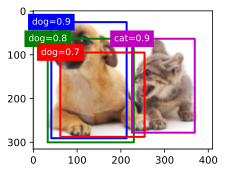

In [84]:
fig = d2l.plt.imshow(img)
show_bboxes(fig.axes, anchors * bbox_scale, # 将锚框的相对坐标转换成在原图的绝对坐标
            ['dog=0.9', 'dog=0.8', 'dog=0.7', 'cat=0.9'])

调用multibox_detection获得经过nms后的预测框信息

我们可以看到返回结果的形状是（批量大小，锚框的数量，6）。 最内层维度中的六个元素提供了同一预测边界框的输出信息。 第一个元素是预测的类索引，从0开始（0代表狗，1代表猫），值-1表示背景或在非极大值抑制中被移除了。 第二个元素是预测的边界框的置信度。 其余四个元素分别是预测边界框左上角和右下角的(x, y)轴坐标（范围介于0和1之间）。

In [85]:
output = multibox_detection(cls_probs.unsqueeze(dim=0),
                            offset_preds.unsqueeze(dim=0),
                            anchors.unsqueeze(dim=0),
                            nms_threshold=0.5)
output

tensor([[[ 0.00,  0.90,  0.10,  0.08,  0.52,  0.92],
         [ 1.00,  0.90,  0.55,  0.20,  0.90,  0.88],
         [-1.00,  0.80,  0.08,  0.20,  0.56,  0.95],
         [-1.00,  0.70,  0.15,  0.30,  0.62,  0.91]]])

删除-1类别（背景）的预测边界框后，我们可以输出由非极大值抑制保存的最终预测边界框。

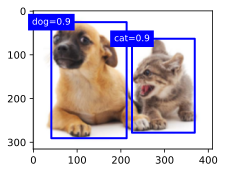

In [86]:
fig = d2l.plt.imshow(img)
for i in output[0].detach().numpy():
    if i[0] == -1:
        continue
    label = ('dog=', 'cat=')[int(i[0])] + str(i[1])
    show_bboxes(fig.axes, [torch.tensor(i[2:]) * bbox_scale], label)

实践中，在执行非极大值抑制前，我们甚至可以将置信度较低的预测边界框移除，从而减少此算法中的计算量。 我们也可以对非极大值抑制的输出结果进行后处理。例如，只保留置信度更高的结果作为最终输出。

## 小结
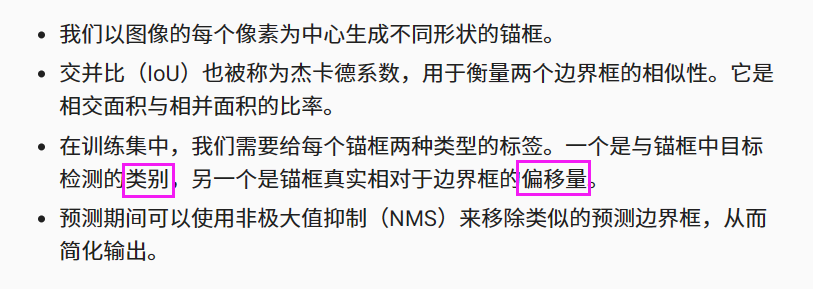